# Wrapper Methods for Feature Selection

## Introduction
In machine learning, not all features are equally useful. Some add noise, some duplicate the same information, and some don’t help at all.  
That’s why **feature selection** is so important — it reduces overfitting, improves interpretability, and often makes models run faster.  

You might already know about **[Filter method ](https://github.com/Aman-sys-ui/Machine_Learning/blob/main/feature_selection/Feature_Selection_Via_Filter_Method.ipynb).**
 (like correlation and chi-square tests). They are quick and simple, but they only look at each feature **individually**, without considering how features work **together**.  



This is where **Wrapper Methods** come in.  
Instead of judging features one by one, wrapper methods **wrap a machine learning model around the feature selection process** and test different feature subsets to find the best combination.  
They are slower than filter methods, but much smarter, because they directly optimize for model performance.

---

## Intuition

Think of feature selection like cooking:  
- **Filter Methods** are like tasting each ingredient separately to see if it’s good.  
- **Wrapper Methods** are like actually trying out different recipes (combinations of ingredients) and picking the one that tastes the best.  

In other words:  
- Wrapper methods don’t just ask, *“Is this feature good on its own?”*  
- They ask, *“Does this feature help when combined with others to improve the model?”*

---

## What I will Cover
1. Exhaustive Feature Selection (Try out all possibilities )
1. Forward Selection (start with none, keep adding useful ones).  
2. Backward Elimination (start with all, remove useless ones).  
3. Recursive Feature Elimination (step-by-step pruning).  
4. Compare performance before and after feature selection.  
5. Discuss **limitations** and **when to use wrapper methods**.  

By the end, this notebook will feel like a mini **guidebook** for wrapper methods — helpful for both learners and professionals.


# Baseline Model for Comparison Without Any Feature Selection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score , confusion_matrix,classification_report
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


In [2]:
# load dataset
data = load_iris()
X = pd.DataFrame(data.data , columns = data.feature_names)
y = data.target

In [5]:
print("shape of the data : ", X.shape)
print("Missing values :\n" ,X.isnull().sum().sort_values(ascending = False ).head())

shape of the data :  (150, 4)
Missing values :
 sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
dtype: int64


In [6]:
# train test split
X_train , X_test ,y_train, y_test = train_test_split(X ,y ,test_size=0.2 , random_state=42 , stratify=y)

In [7]:
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

In [8]:
# Logistic regression as base moddel
base_model = LogisticRegression(max_iter = 5000)
base_model.fit(X_train ,y_train)

LogisticRegression(max_iter=5000)

In [9]:
# prediction
y_pred = base_model.predict(X_test)

In [25]:
# Baseline model (all features)
baseline_scores = cross_val_score(base_model, X, y, cv=5, scoring="accuracy")
print("Baseline Mean CV Accuracy:", baseline_scores.mean())

Baseline Mean CV Accuracy: 0.9733333333333334


In [24]:
baseline_acuuracy = accuracy_score(y_test ,y_pred)
print("Baseline Acuuracy score :" ,baseline_acuuracy)
print("Confusion matrix :\n" ,confusion_matrix(y_test ,y_pred))
print("classification report:" ,classification_report(y_test ,y_pred))

Baseline Acuuracy score : 0.9333333333333333
Confusion matrix :
 [[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]
classification report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



#1 .Exhaustive Feature Selection (EFS)

## What is Exhaustive Feature Selection?
Exhaustive Feature Selection tries **all possible combinations** of features and picks the best one.  
It’s the most **brute-force** but also the most **reliable** way of finding the optimal feature subset.  

For example, if you have 3 features (A, B, C), EFS will check:  
- A  
- B  
- C  
- A + B  
- A + C  
- B + C  
- A + B + C  

…and then pick the subset that gives the highest model performance.  

---

## Intuition
Imagine you’re at an ice cream shop.  
You’re not sure which flavor combo you’ll like the most, so you **try every possible combination** of scoops (vanilla, chocolate, strawberry, vanilla+chocolate, etc.) until you find your favorite.  

That’s exactly what EFS does — it tries **every possible mix of features** to find the best set.


Note: We are applying Exhaustive Feature Selection (EFS) on the Iris dataset.  
Since the dataset has only 4 features, exhaustive search is computationally feasible.  
On larger datasets (with >15 features), EFS can become extremely slow and impractical.


In [16]:
# logistic regression as base model
log_reg = LogisticRegression(max_iter=5000)

# exhaustive search >-- very slow if features > 15
efs = EFS(log_reg,
          min_features=1,
          max_features= 4,   # to keep runtime reasonable
          scoring="accuracy",
          cv=5,
          n_jobs=-1)
# too time consuming
efs = efs.fit(X_train, y_train)



Features: 15/15

In [20]:
print("Best CV Accuracy Score:", efs.best_score_)
print("Best Feature Subset:", efs.best_feature_names_)


Best accuracy score (CV): 0.9666666666666668
Best feature subset: ('3',)


### Interpretation of EFS Results

- The best accuracy score achieved was **96.67%** using just **one feature**: **Petal Width**.  
- This is very interesting, because it shows that not all features are equally important — sometimes, a single feature can be highly predictive.  
- In the Iris dataset, petal measurements (especially petal width) are known to separate the three flower species quite well.  
- This aligns with what we expect from domain knowledge: **setosa flowers** usually have very small petals, while **virginica** has much larger ones.  


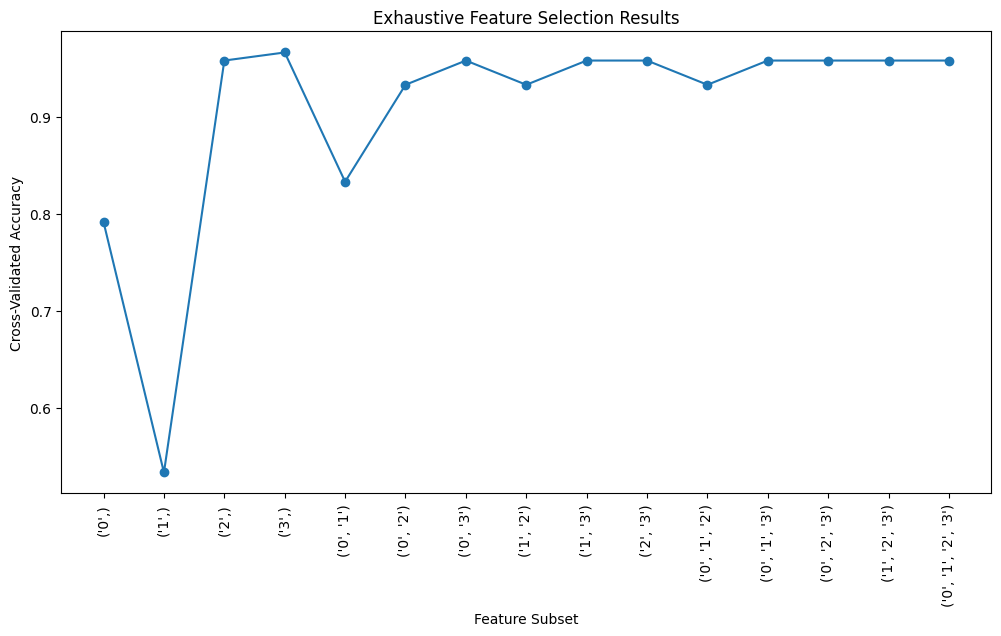

In [22]:
# Convert Results to DataFrame
metric_dict = efs.get_metric_dict()
metric_df = pd.DataFrame.from_dict(metric_dict).T

# plot scores
plt.figure(figsize=(12,6))
plt.plot([str(m["feature_names"]) for m in metric_dict.values()],
         [m["avg_score"] for m in metric_dict.values()],
         marker="o")
plt.xticks(rotation=90)
plt.xlabel("Feature Subset")
plt.ylabel("Cross-Validated Accuracy")
plt.title("Exhaustive Feature Selection Results")
plt.show()


In [31]:
# EFS-selected model (petal width only)
X_best = X.iloc[:, [3]]  # only feature index 3
efs_scores = cross_val_score(log_reg, X_best, y, cv=5, scoring="accuracy")
print("EFS-Selected Features Mean CV Accuracy:", efs_scores.mean())

EFS-Selected Features Mean CV Accuracy: 0.96


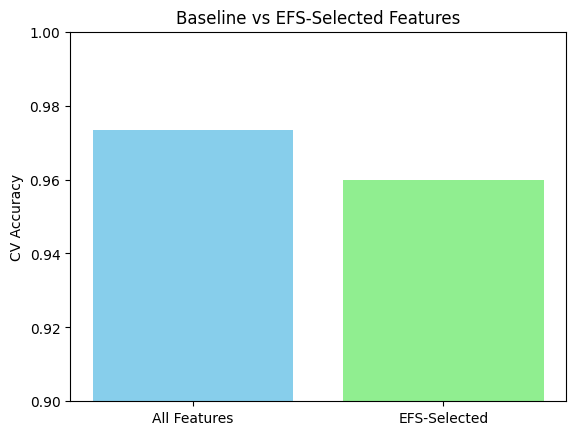

In [33]:
scores = [baseline_scores.mean(), efs_scores.mean()]
labels = ["All Features", "EFS-Selected"]

plt.bar(labels, scores, color=["skyblue", "lightgreen"])
plt.ylabel("CV Accuracy")
plt.title("Baseline vs EFS-Selected Features")
plt.ylim(0.9, 1.0)  # zoom into accuracy range
plt.show()


### Cross-Validation Insights

- Using **all 4 features**, Logistic Regression reached a mean CV accuracy of **97.3%**.  
- Using only the **EFS-selected feature (Petal Width)**, the accuracy was **96.0%**.  

This means we lose only about **1.3% accuracy** while reducing the model to a **single feature**.  

**Practical takeaway:**  
- In small datasets like Iris, a single strong feature can almost match the performance of all features.  
- In real-world problems, feature selection is valuable for **reducing model complexity, training time, and avoiding overfitting** — even if it means trading off a tiny bit of accuracy.


## Pros and Cons of Exhaustive Feature Selection (EFS)

### Pros
- **Gold Standard**: Finds the *truly best* subset of features because it literally tries every possible combination.  
- **Benchmark Value**: Great for small datasets to serve as a baseline against which we can compare faster methods (Forward, Backward, RFE).  
- **No Greedy Choices**: Unlike Forward/Backward Selection, it doesn’t get stuck with early “bad” choices, since it evaluates all subsets.  
- **Interpretability**: Helps us understand exactly which features work best together.  

Example:  
If you only have 8 patient lab tests, EFS can try all possible subsets to identify the **perfect combination** for diagnosis.

---

### Cons
- **Computationally Explosive**: With 30 features, there are over 1 billion subsets — runtime becomes impractical.  
- **Not Scalable**: Cannot be used in high-dimensional datasets (like text, images, or genomics).  
- **Overfitting Risk**: Since it explores so many combinations, it might find a subset that works great on training/cross-validation but doesn’t generalize well.  
- **Slow in Practice**: Even with parallelization, it’s only feasible for small to medium feature spaces.  

Example:  
Trying EFS on a dataset with 100 features is like **testing every possible recipe in a cookbook with thousands of ingredients** — it’s just not realistic.  

---

**In short:**  
EFS is the “gold standard” for feature selection, but only practical when you have **very few features**. For larger datasets, Forward, Backward, or RFE are better trade-offs between **accuracy and speed**.  


# 2. Forward Selection

**Idea:**  
Forward selection starts with **no features**.  
Then, it adds features **one by one** — at each step choosing the feature that improves the model performance the most.  
The process continues until adding more features doesn’t make things better.

**Intuition Example:**  
Imagine you are packing items for a trip.  
- You start with an empty bag.  
- First, you add the most essential item (say, your passport).  
- Then you add the next most useful (money, clothes, phone charger…).  
- You stop adding when the bag is full enough, and more items would just make it heavy.  

That’s exactly what forward selection does with features: build the “bag” step by step until performance stops improving.


In [ ]:
# forward selection
sfs = SFS(
    model,
    k_features = "best",  # search between 1 and all features
    forward=True,       # forward selection
    floating=False,     # strict forward, not stepwise
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)

In [ ]:
sfs.fit(X_train ,y_train)

SequentialFeatureSelector(estimator=LogisticRegression(max_iter=5000),
                          k_features=(1, 30), n_jobs=-1, scoring='accuracy')

In [ ]:
# best feature subset
print("Best accuracy score :" ,sfs.k_score_)
print("Selected feature :" ,list(sfs.k_feature_names_))

Best accuracy score : 0.9868131868131869
Selected feature : ['1', '3', '4', '6', '8', '18', '20', '22', '23', '24']


**Feature subset chosen at each step**

In [ ]:
# get the full metric dictionary
metric_dict = sfs.get_metric_dict()

# convert into dataframe
metric_df = pd.DataFrame.from_dict(metric_dict).T

# add useful columns
metric_df['num_features'] = metric_df['feature_idx'].apply(lambda x: len(x))
metric_df['feature_names'] = metric_df['feature_names'].apply(lambda x: list(x))

# sort by accuracy
metric_df = metric_df.sort_values(by="avg_score", ascending=False)
metric_df.head(10)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,num_features
16,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 18, 20, 22, 23...","[0.989010989010989, 1.0, 0.967032967032967, 0....",0.986813,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 18, 20, 22, 23...",0.013839,0.010767,0.005383,16
21,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 16,...","[0.989010989010989, 1.0, 0.967032967032967, 0....",0.986813,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 16,...",0.013839,0.010767,0.005383,21
20,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 16, 18,...","[0.989010989010989, 1.0, 0.967032967032967, 0....",0.986813,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 16, 18,...",0.013839,0.010767,0.005383,20
19,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 16, 18,...","[0.989010989010989, 1.0, 0.967032967032967, 0....",0.986813,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 16, 18,...",0.013839,0.010767,0.005383,19
18,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 16, 18, 20,...","[0.989010989010989, 1.0, 0.967032967032967, 0....",0.986813,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 16, 18, 20,...",0.013839,0.010767,0.005383,18
10,"(1, 3, 4, 6, 8, 18, 20, 22, 23, 24)","[0.989010989010989, 1.0, 0.967032967032967, 0....",0.986813,"[1, 3, 4, 6, 8, 18, 20, 22, 23, 24]",0.013839,0.010767,0.005383,10
11,"(0, 1, 3, 4, 6, 8, 18, 20, 22, 23, 24)","[0.989010989010989, 1.0, 0.967032967032967, 0....",0.986813,"[0, 1, 3, 4, 6, 8, 18, 20, 22, 23, 24]",0.013839,0.010767,0.005383,11
12,"(0, 1, 3, 4, 6, 7, 8, 18, 20, 22, 23, 24)","[0.989010989010989, 1.0, 0.967032967032967, 0....",0.986813,"[0, 1, 3, 4, 6, 7, 8, 18, 20, 22, 23, 24]",0.013839,0.010767,0.005383,12
17,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 18, 20, 22,...","[0.989010989010989, 1.0, 0.967032967032967, 0....",0.986813,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 18, 20, 22,...",0.013839,0.010767,0.005383,17
15,"(0, 1, 2, 3, 4, 6, 7, 8, 13, 18, 20, 22, 23, 2...","[0.989010989010989, 1.0, 0.967032967032967, 0....",0.984615,"[0, 1, 2, 3, 4, 6, 7, 8, 13, 18, 20, 22, 23, 2...",0.014404,0.011207,0.005603,15


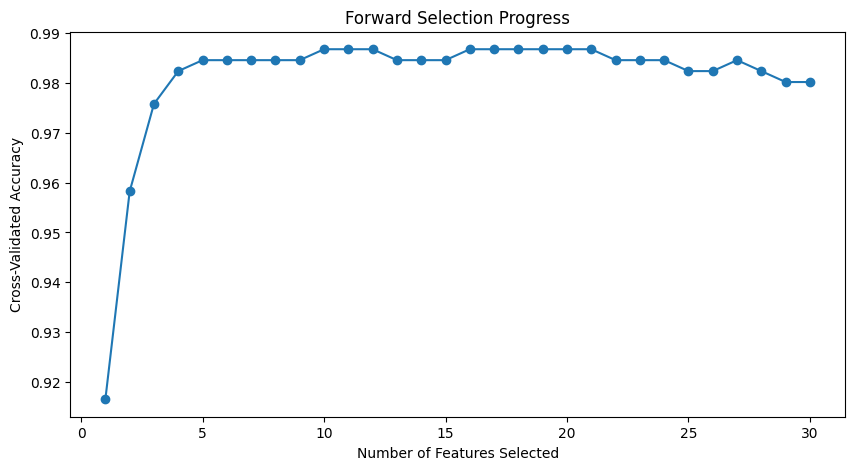

In [ ]:
# plot performance over number of features
metric_dict = sfs.get_metric_dict()
scores = [metric_dict[i]["avg_score"] for i in range(1, len(metric_dict) + 1)]

plt.figure(figsize=(10,5))
plt.plot(range(1, len(scores)+1), scores, marker="o")
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validated Accuracy")
plt.title("Forward Selection Progress")
plt.show()


In [ ]:
# model with SFS -selected features
X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_test)

In [ ]:
# training model
log_reg.fit(X_train_sfs, y_train)
# prediction
y_pred_sfs = log_reg.predict(X_test_sfs)
sfs_acc = accuracy_score(y_test, y_pred_sfs)
print("Accuracy with SFS-selected features:", sfs_acc)

Accuracy with SFS-selected features: 0.9385964912280702


In [ ]:
# Comparison
print("Comparison of Models:")
print(f"Baseline (all features): {baseline_acuuracy:.4f}")
print(f"SFS-selected features  : {sfs_acc:.4f}")

Comparison of Models:
Baseline (all features): 0.9825
SFS-selected features  : 0.9386


Observation:  
Even though SFS gave a higher accuracy during cross-validation (0.9868), the actual test performance (0.9386) was worse than the baseline (0.9825).  

This shows an important lesson: **wrapper methods like SFS can overfit** if not carefully validated.  
- Always compare with a baseline model.  
- A smaller feature subset is not always better if it hurts generalization.  


In [ ]:
from sklearn.model_selection import StratifiedKFold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

log_reg = LogisticRegression(max_iter=5000)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

outer_scores = []

for train_idx, test_idx in outer_cv.split(X, y):
    # use .iloc for row selection
    X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # inner CV feature selection
    sfs = SFS(log_reg,
              k_features="best",
              forward=True,
              scoring="accuracy",
              cv=3,
              n_jobs=-1)

    sfs.fit(X_train, y_train)

    # Transform data with best features
    X_train_sfs = sfs.transform(X_train)
    X_test_sfs = sfs.transform(X_test)

    # Train and evaluate
    log_reg.fit(X_train_sfs, y_train)
    y_pred = log_reg.predict(X_test_sfs)

    acc = accuracy_score(y_test, y_pred)
    outer_scores.append(acc)

print("Nested CV accuracy:", np.mean(outer_scores))


📊 Baseline CV Accuracy (all features): 0.9507995652848935

✅ SFS Best CV Accuracy: 0.95960254618848
📌 Selected features: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry']


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

## When to Use Forward Selection (SFS)?

- When you have **many features** and want to find the most useful subset instead of blindly using them all.  
- When you care about **interpretability** (smaller feature sets are easier to explain to non-technical people).  
- When you suspect that **not all features are relevant** and some may add noise.  
- When you’re working with **medium-sized datasets** where training multiple models is still feasible.  

Example:  
Imagine you’re predicting whether a patient has a disease. The dataset has 30 medical measurements.  
Doctors don’t want to rely on all 30 — they’d prefer 5–10 strong indicators that make sense clinically.  
SFS helps here by picking the most relevant measurements while keeping accuracy high.  

---

## Problems with Forward Selection (SFS)

- **Computationally expensive**: It trains the model many times, especially if you have hundreds of features.  
- **Greedy approach**: Once it adds a feature, it doesn’t go back and reconsider.  
  - Example: It might pick a feature early on that looks good alone, but later it turns out not to be useful with others. Too late — it’s already locked in.  
- **Risk of overfitting**: If dataset is small, SFS might “cherry-pick” features that look good on cross-validation but don’t generalize well.  
- **Not great for very high-dimensional data** (like gene expression or NLP with thousands of features). In such cases, filter methods or embedded methods (like Lasso) are more practical.  

---

**In short:** Use SFS when you want **interpretability + solid performance** on medium datasets.  
Avoid it when you’re working with **huge feature spaces** or need **fast feature selection**.  


# 3 .Backward Elimination

## What is Backward Elimination?
Backward Elimination is the **opposite of Forward Selection**.  
Instead of starting with no features, it starts with **all features** and then removes them one by one.  
At each step, it drops the feature that contributes the least to the model’s performance.  

Think of it as “peeling an onion”:  
- Start with everything.  
- Keep removing the weakest layer (feature) at each step.  
- Stop when removing more layers starts hurting performance.

---

## Intuition
Imagine you’re packing your travel bag.  
- At first, you throw in **all items** (clothes, shoes, books, gadgets).  
- But your bag is too heavy.  
- So you start removing items that you need the least (like the extra pair of shoes or that heavy book).  
- Finally, you’re left with a **light but useful bag** that still has everything important.  

That’s exactly what Backward Elimination does with features.


In [ ]:
# logistic regression as base model
model = LogisticRegression(max_iter=5000)

In [ ]:
# backward elimination
sfs_back = SFS(
               model,
               k_features="best",  # let it decide optimal number of features
               forward=False,      # backward elimination
               floating=False,     # strict backward, not stepwise
               scoring="accuracy",
               cv=5,
               n_jobs=-1)

sfs_back = sfs_back.fit(X_train, y_train)

In [ ]:
# best feature subset
print("Best accuracy score:", sfs_back.k_score_)
print("Selected features:", list(sfs_back.k_feature_names_))

Best accuracy score: 0.9846153846153847
Selected features: ['0', '1', '2', '3', '4', '5', '7', '8', '9', '10', '11', '12', '13', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '27', '28']


In [ ]:
# get the full metric dictionary
metric_dict = sfs_back.get_metric_dict()

# convert into dataframe
metric_df = pd.DataFrame.from_dict(metric_dict).T

# add useful columns
metric_df['num_features'] = metric_df['feature_idx'].apply(lambda x: len(x))
metric_df['feature_names'] = metric_df['feature_names'].apply(lambda x: list(x))

# sort by accuracy
metric_df = metric_df.sort_values(by="avg_score", ascending=False)
metric_df.head(10)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,num_features
15,"(0, 1, 2, 9, 10, 11, 13, 15, 17, 18, 20, 21, 2...","[0.978021978021978, 0.989010989010989, 0.96703...",0.984615,"[0, 1, 2, 9, 10, 11, 13, 15, 17, 18, 20, 21, 2...",0.014404,0.011207,0.005603,15
21,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 15...","[0.978021978021978, 0.989010989010989, 0.96703...",0.984615,"[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 15...",0.014404,0.011207,0.005603,21
12,"(0, 1, 10, 11, 13, 15, 17, 18, 21, 24, 27, 28)","[0.978021978021978, 0.989010989010989, 0.97802...",0.984615,"[0, 1, 10, 11, 13, 15, 17, 18, 21, 24, 27, 28]",0.006919,0.005383,0.002692,12
13,"(0, 1, 10, 11, 13, 15, 17, 18, 20, 21, 24, 27,...","[0.978021978021978, 0.989010989010989, 0.96703...",0.984615,"[0, 1, 10, 11, 13, 15, 17, 18, 20, 21, 24, 27,...",0.014404,0.011207,0.005603,13
14,"(0, 1, 2, 10, 11, 13, 15, 17, 18, 20, 21, 24, ...","[0.978021978021978, 0.989010989010989, 0.96703...",0.984615,"[0, 1, 2, 10, 11, 13, 15, 17, 18, 20, 21, 24, ...",0.014404,0.011207,0.005603,14
16,"(0, 1, 2, 3, 9, 10, 11, 13, 15, 17, 18, 20, 21...","[0.978021978021978, 0.989010989010989, 0.96703...",0.984615,"[0, 1, 2, 3, 9, 10, 11, 13, 15, 17, 18, 20, 21...",0.014404,0.011207,0.005603,16
17,"(0, 1, 2, 3, 9, 10, 11, 12, 13, 15, 17, 18, 20...","[0.978021978021978, 0.989010989010989, 0.96703...",0.984615,"[0, 1, 2, 3, 9, 10, 11, 12, 13, 15, 17, 18, 20...",0.014404,0.011207,0.005603,17
18,"(0, 1, 2, 3, 7, 9, 10, 11, 12, 13, 15, 17, 18,...","[0.978021978021978, 0.989010989010989, 0.96703...",0.984615,"[0, 1, 2, 3, 7, 9, 10, 11, 12, 13, 15, 17, 18,...",0.014404,0.011207,0.005603,18
19,"(0, 1, 2, 3, 4, 7, 9, 10, 11, 12, 13, 15, 17, ...","[0.978021978021978, 0.989010989010989, 0.96703...",0.984615,"[0, 1, 2, 3, 4, 7, 9, 10, 11, 12, 13, 15, 17, ...",0.014404,0.011207,0.005603,19
20,"(0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 15, 1...","[0.978021978021978, 0.989010989010989, 0.96703...",0.984615,"[0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 15, 1...",0.014404,0.011207,0.005603,20


**Visulaizing Backward Eliminaton Progress**

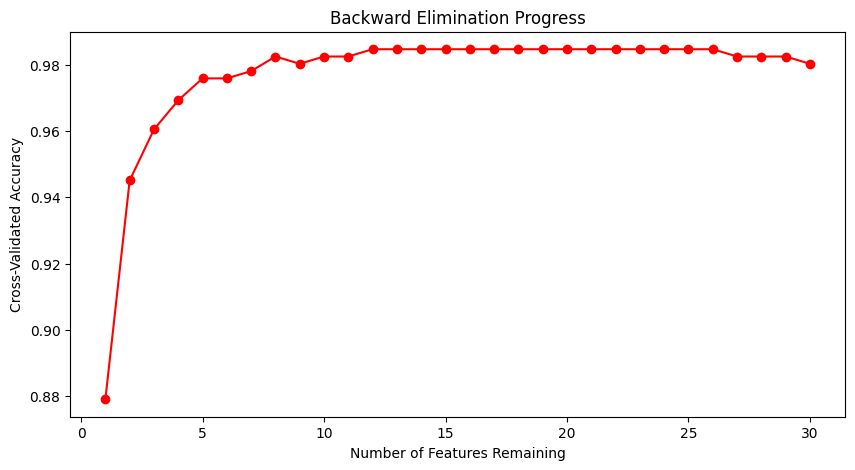

In [ ]:
# extract performance history
metric_dict_back = sfs_back.get_metric_dict()
scores_back = [metric_dict_back[i]["avg_score"] for i in range(1, len(metric_dict_back) + 1)]

plt.figure(figsize=(10,5))
plt.plot(range(1, len(scores_back)+1), scores_back, marker="o", color="red")
plt.xlabel("Number of Features Remaining")
plt.ylabel("Cross-Validated Accuracy")
plt.title("Backward Elimination Progress")
plt.show()


## When to Use Backward Elimination?

- When you have a **moderate number of features** (not thousands).  
- When you want to start with **all possible predictors** and carefully prune down.  
- When you suspect that **most features are useful**, but you want to remove the least important ones.  
- When interpretability matters, and you want a **cleaner model** with fewer variables.  

Example:  
Imagine a doctor has 30 medical tests for cancer detection. Instead of guessing which ones to use, she starts with all of them.  
Backward Elimination helps by removing the least useful tests one by one until only the **most critical ones remain**.  

---

## Problems with Backward Elimination

- **Computationally heavy** if you have a large number of features, since it starts big and prunes down.  
- **Greedy nature**: Once it removes a feature, it never brings it back, even if it could have been useful in combination with others.  
- **Risk of overfitting**: Similar to forward selection, it may tailor the selected features to the training data and not generalize well.  
- **Needs enough samples**: If dataset is small, performance estimates during elimination may be unstable.  
- **Not suitable for high-dimensional data** (like thousands of text or gene features) — wrapper methods become too slow, and embedded methods like Lasso are better.  

---

**In short:** Backward Elimination is great if you can start with everything and want to **prune carefully**, but avoid it when the feature space is **huge**.  


# Recursive Feature Elimination (RFE)

## What is RFE?
Recursive Feature Elimination (RFE) is a **systematic way** of removing the weakest features step by step.  
Instead of just doing one round of elimination like backward selection, RFE keeps repeating the process until only the desired number of features remain.  

It’s like a tournament:  
- All features start in the competition.  
- At each round, the **least useful feature gets eliminated**.  
- The tournament continues until only the “champion features” are left.

---

## Intuition (Human Example)
Imagine you’re trying to find the best basketball team lineup:  
- You start with all players.  
- In each round, you cut the weakest player.  
- You repeat this process until you’re left with the top 5 players.  

That’s exactly what RFE does — it keeps “firing” the weakest features until the best team remains.
